In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA

from qiskit import transpile
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Operator
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit

from algo.utils_qiskit import find_pauli_indices
from utils import hamiltonian_to_matrix
from algo.utils_qiskit import process_hamiltonian_Zs

In [2]:
ham_str = '0.5 - 3 * z0  + 0.5 * z1 * z0 + 0.5 * z2 * z0 + 0.5 * z2 * z1 + 0.5 * z3 * z0 + 0.5 * z3 * z2'
num_q = 4  # Number of qubits
max_stars = 2  # Maximum number of stars to categorize terms (e.g., 0-star, 1-star, 2-star, 3-star)

# Call the function to process the Hamiltonian string
all_lists, all_coeffs = process_hamiltonian_Zs(ham_str, num_q, max_stars)

# Output the results for each star category
for i, (term_positions, term_coeffs) in enumerate(zip(all_lists, all_coeffs)):
    print(f"Terms with {i} star(s):")
    print("Coefficients:", term_coeffs)
    print("Positions:", term_positions)

print('')

List_0, List_1, List_2 = all_lists
List = List_0 + List_1 + List_2

coeff_0, coeff_1, coeff_2 = all_coeffs
coeff = coeff_0 + coeff_1 + coeff_2

H = SparsePauliOp(List, coeff)
Hmat = Operator(H)
Hmat = Hmat.data

# CHECK IT IS THE SAME AS MATRIX FROM JAX PROBLEM
H2 = hamiltonian_to_matrix(ham_str)
print('difference between two matrices', np.linalg.norm(H2-Hmat.data))

e, v = LA.eig(Hmat) # Compute the eigenvalues and right eigenvectors of a square array.
min_index = np.argmin(e)
v_min = v[:,min_index] # ground state (eigenvector)
ground_e = np.min(e) # ground state energy
print('ground state energy',ground_e)
print('hamiltonian strings size',H.size)
# print(H)
print(e)

Terms with 0 star(s):
Coefficients: [0.5]
Positions: ['IIII']
Terms with 1 star(s):
Coefficients: [-3.0]
Positions: ['ZIII']
Terms with 2 star(s):
Coefficients: [0.5, 0.5, 0.5, 0.5, 0.5]
Positions: ['ZZII', 'ZIZI', 'IZZI', 'ZIIZ', 'IIZZ']

difference between two matrices 0.0
ground state energy (-4+0j)
hamiltonian strings size 7
[ 0.+0.j -2.+0.j -3.+0.j -3.+0.j -2.+0.j -4.+0.j -3.+0.j -3.+0.j  3.+0.j
  3.+0.j  2.+0.j  4.+0.j  3.+0.j  3.+0.j  4.+0.j  6.+0.j]


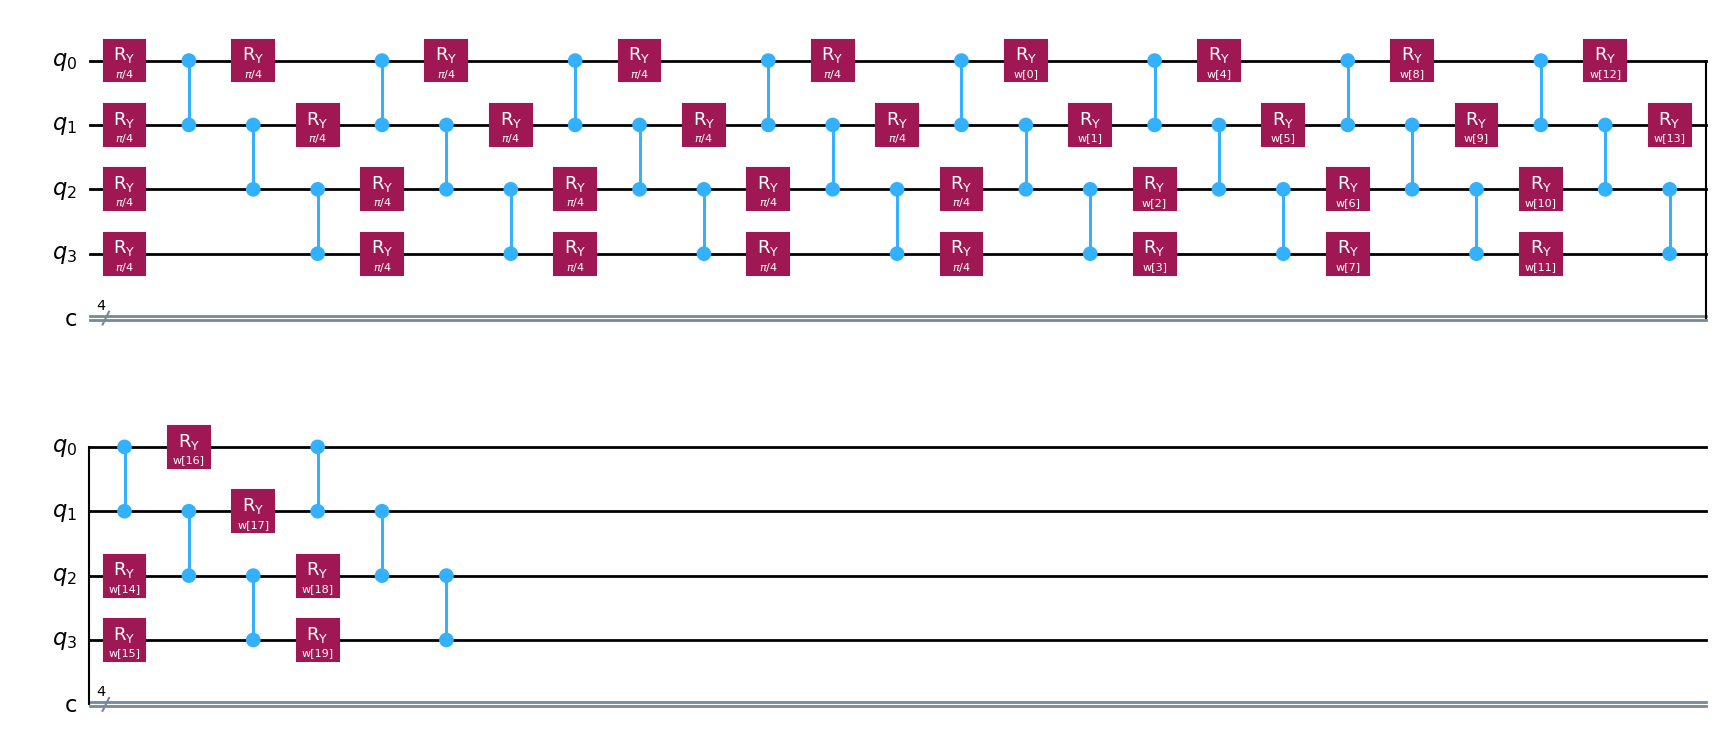

In [3]:
"""circuit construction"""
layer = 5  # Define the number of layers in the quantum circuit

# This needs to be determined based on the circuit
num_p = num_q * layer  # Calculate the number of parameters 

weights = ParameterVector("w", num_p)  # Create a vector of parameters (parameters of the quantum circuit)

# Hardware-Efficient Ansatz
def circuit_HEA(weights):
    # ``QuantumCircuit(4, 3) 
    # A QuantumCircuit with 4 qubits and 3 classical bits
    circ = QuantumCircuit(num_q, num_q)  
    
    for i in range(layer):
        # initial state is not |0⟩^⊗n
        for j in range(num_q): 
            circ.ry(np.pi/4, j)  # Apply RY gate to each qubit, the angle is given by elements in the weights array
        for j in range(num_q-1):  
            circ.cz(j, j+1) # Apply CZ gate to each pair of adjacent qubits


    for i in range(layer):  # Iterate over each layer
        for j in range(num_q): 
            circ.ry(weights[num_q*i+j], j)  # Apply RY gate to each qubit, the angle is given by elements in the weights array
        for j in range(num_q-1):  
            circ.cz(j, j+1) # Apply CZ gate to each pair of adjacent qubits
    
    return circ  # Return the constructed quantum circuit

qc = circuit_HEA(weights)
# print(qc)
qc.draw("mpl")


In [4]:
simulator = AerSimulator()

Z_indices = []
ZZ_indices = []

for pauli_str in List_1:
    # print(pauli_str)
    _, _, Z_index = find_pauli_indices(pauli_str)
    Z_indices.append(Z_index)

for pauli_str in List_2:
    # print(pauli_str)
    _, _, ZZ_index = find_pauli_indices(pauli_str)
    ZZ_indices.append(ZZ_index)

def estimate_loss(WEIGHTS, SHOTS):

    estimate_1 = 0 
    estimate_2 = 0

    qc = circuit_HEA(WEIGHTS)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc)

    for i in range(SHOTS):
        
        c_i = c[i]

        # List_1 = ['ZIII'] Terms with 1 star
        for j, index in enumerate(Z_indices): 
            if c_i[num_q-1-index[0]] == '0':
                estimate_1 += 1*coeff_1[j]
            else:
                estimate_1 += -1*coeff_1[j]
        
        # List_2 = ['ZZII', 'ZIZI', 'IZZI', 'ZIIZ', 'IIZZ'] Terms with 2 stars
        for j, index in enumerate(ZZ_indices): 
            if c_i[num_q-1-index[0]] == c_i[num_q-1-index[1]]:
                estimate_2 += 1*coeff_2[j]
            else:
                estimate_2 += -1*coeff_2[j]
        

    estimate = estimate_1 + estimate_2
    estimate = estimate/SHOTS + coeff_0[0] # coeff_0[0] for 'IIII'

    return estimate



def expectation_loss(WEIGHTS):
    qc = circuit_HEA(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    Hpsi = Hmat.dot(psi)
    expectation = np.inner(np.conjugate(psi),Hpsi)
    return np.real(expectation)


def fidelity(WEIGHTS):
    qc = circuit_HEA(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    return np.absolute(np.vdot(psi,v_min))**2

def sd(WEIGHTS):
    qc = circuit_HEA(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    Hmat_sqaured =  Hmat @ Hmat
    Hmat_sqauredpsi = Hmat_sqaured.dot(psi)
    var = np.inner(np.conjugate(psi),Hmat_sqauredpsi) - expectation_loss(WEIGHTS)**2
    return np.sqrt(np.real(var))



In [5]:
weights = np.random.uniform(0, 2*np.pi, size=num_p)

print(expectation_loss(weights))
print(sd(weights))
print(expectation_loss(weights)/sd(weights))

# Check if the observed values from the simulator follow a normal distribution
# Essentially, this is to check whether the estimate_loss function is correct
# It takes a long time
shots = 1000
if False:
    true_value = expectation_loss(weights)

    # 收集多次估计结果
    num_trials = 2000
    estimate_results = [estimate_loss(weights, shots) for _ in range(num_trials)]

    # 绘制结果
    plt.figure(figsize=(10, 6))
    plt.hist(estimate_results, bins=30, density=True, alpha=0.6, color='g', label='Estimation Results')
    plt.axvline(true_value, color='r', linestyle='--', label=f'True Value = {true_value}')
    plt.title('Distribution of estimate_Z outputs')
    plt.xlabel('Estimated Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()



0.7455939390347386
2.99564477491758
0.24889264083564525


In [6]:
from check_utils import interp_matrix

weights_dict = {}

omegas = [1]
interp_nodes = np.linspace(0,2*np.pi,2*len(omegas)+1,endpoint=False)
# interp_nodes = np.random.uniform(0, 2*np.pi, size=2*len(omegas)+1)
inverse_interp_matrix = np.linalg.inv(interp_matrix(interp_nodes, omegas))

for i in range(num_p):
    weights_dict[f'weights_{i}'] = {
        'omegas': omegas,
        'interp_nodes': interp_nodes,
        'inverse_interp_matrix': inverse_interp_matrix,
    }

print(weights_dict['weights_0'])
print(f'true ground state energy:',ground_e)

{'omegas': [1], 'interp_nodes': array([0.       , 2.0943951, 4.1887902]), 'inverse_interp_matrix': array([[ 4.71404521e-01,  4.71404521e-01,  4.71404521e-01],
       [ 6.66666667e-01, -3.33333333e-01, -3.33333333e-01],
       [-1.92296269e-16,  5.77350269e-01, -5.77350269e-01]])}
true ground state energy: (-4+0j)


In [7]:
# Verify if the function can be accurately interpolated by trigonometric interpolation based on omegas

from check_utils import check_is_trigometric  # Assuming check_is_trigometric is defined in check_utils module

# Define random weights
weights = np.random.normal(0, 4 * np.pi**2, num_p)

# Loop over each weight index and check trigonometric interpolation
for j in range(num_p):
    # Circuit_HEA is simple and all Hermitian generators are Y.
    omegas = omegas = weights_dict[f'weights_{j}']['omegas']  # This needs to be determined based on the circuit (i.e., parameters to test interpolation)
    
    print('\n index to check = ', j)
    print('omegas = ', omegas)
    
    opt_interp_flag = False  # Flag to indicate if optimal interpolation should be used
    
    # Call the function to check if the objective function can be interpolated using trigonometric interpolation
    check_is_trigometric(expectation_loss, j, omegas, weights, opt_interp_flag)




 index to check =  0
omegas =  [1]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [ 1.38947365 -0.14086859 -0.17568354]

 index to check =  1
omegas =  [1]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [ 1.82879622 -0.36397877 -0.29651908]

 index to check =  2
omegas =  [1]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [ 1.20211524  0.6663908  -0.68248705]

 index to check =  3
omegas =  [1]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [ 1.18217331 -0.17235799 -0.49274558]

 index to check =  4
omegas =  [1]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [0.50396203 0.15455251 0.33648471]

 index to check =  5
omegas =  [1]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [ 0.25060594 -0.04955262 -0.25046823]

 index to check =  6
omegas =  [1]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [ 0.29701733 -0.03669322 -0.63777508]

 index to check =  7
o

In [7]:
# initial_weights = np.zeros(num_p) #np.ones(num_p)
initial_weights = np.random.uniform(0, 2*np.pi, size=num_p)
n_shot = 1000

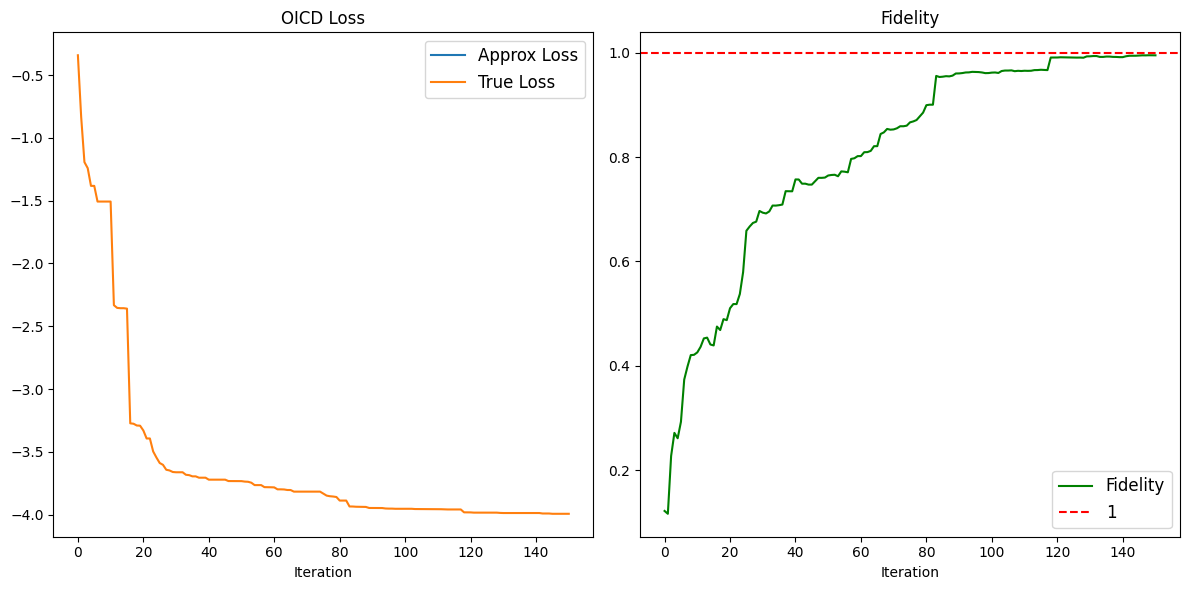

[OICD] Iter: 149 - Coord: 16(20), Best loss: -3.9934576345759845, True loss: -3.992305685020703, Fidelity: 0.9947999653487342: 100%|██████████| 150/150 [01:29<00:00,  1.67it/s]


In [8]:
# OICD Optimization
from algo.oicd_qiskit import oicd

num_iters = 150
# Run OICD
final_weights_oicd, best_expected_record_value_oicd, fidelity_record_value_oicd, func_oicd = oicd(
    estimate_loss,
    expectation_loss,
    fidelity,
    n_shot, weights_dict, initial_weights, num_iters,
    subproblem_method='CG',  # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
    subproblem_iter=None,
    cyclic_mode=False,  # False is very fast.
    use_solvers_flag=False,
    use_pratical_interp_flag=True,
    exact_mode=False,
    plot_flag=True,
)


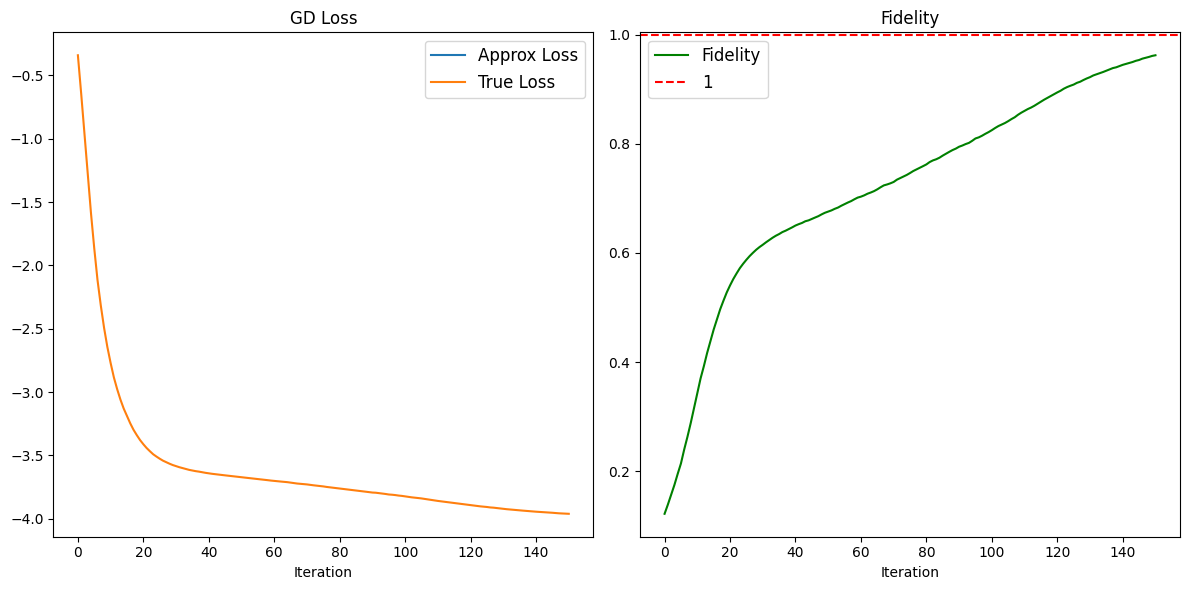

[GD] Iter: 149, Best loss: -3.9609599993856515, True loss: -3.9609599993856515, Fidelity: 0.9619939542932407: 100%|██████████| 150/150 [04:25<00:00,  1.77s/it]


In [9]:

# Gradient Descent Optimization
from algo.gd_qiskit import gd

num_iters = 150
# Run GD
final_weights_gd, best_expected_record_value_gd, fidelity_record_value_gd, func_gd = gd(
    estimate_loss,
    expectation_loss,
    fidelity,
    n_shot, weights_dict, initial_weights, num_iters,
    learning_rate=0.05,
    exact_mode=False,
    plot_flag=True,
)


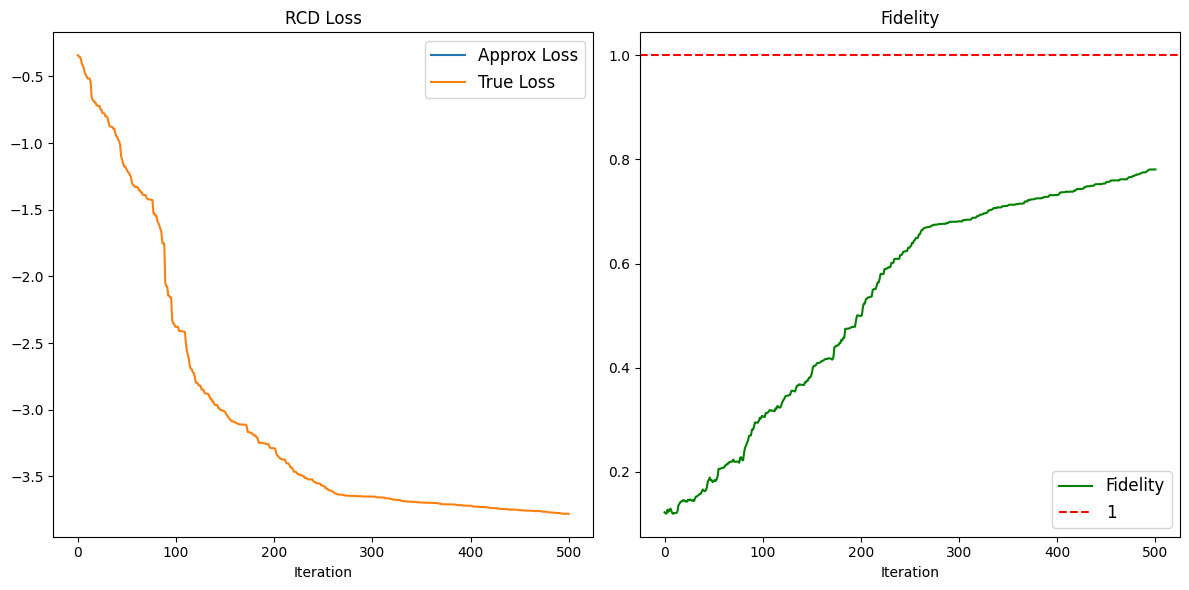

[RCD] Iter: 499, Best loss: -3.779653574964404, True loss: -3.779653574964404, Fidelity: 0.7807020838774673: 100%|██████████| 500/500 [03:19<00:00,  2.51it/s]


In [10]:

# RCD Optimization
from algo.rcd_qiskit import rcd

num_iters = 500
# Run RCD
final_weights_rcd, best_expected_record_value_rcd, fidelity_record_value_rcd, func_rcd= rcd(
    estimate_loss,
    expectation_loss,
    fidelity,
    n_shot, weights_dict, initial_weights, num_iters,
    learning_rate=0.1,
    cyclic_mode=False,
    exact_mode=False,
    plot_flag=True,
)


c:\ProgramData\anaconda3\envs\RCD\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


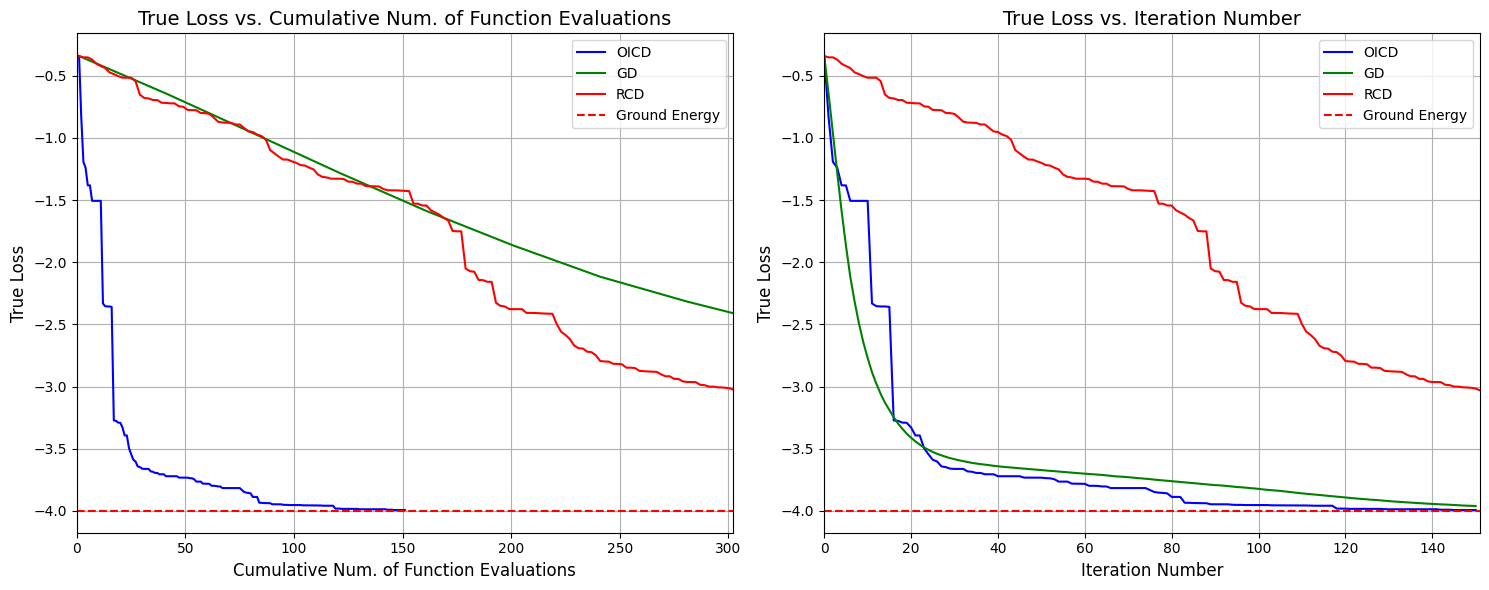

In [11]:
import matplotlib.pyplot as plt

# 创建一个1x2的子图布局
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# 第一个子图：横坐标是累计函数调用次数，纵坐标是函数值
axs[0].plot(func_oicd, best_expected_record_value_oicd, label='OICD', color='blue')
axs[0].plot(func_gd, best_expected_record_value_gd, label='GD', color='green')
axs[0].plot(func_rcd, best_expected_record_value_rcd, label='RCD', color='red')
axs[0].axhline(y=ground_e, color='r', linestyle='--', label='Ground Energy')

# 设置第一个子图的标签和标题
axs[0].set_xlabel('Cumulative Num. of Function Evaluations', fontsize=12)
axs[0].set_ylabel('True Loss', fontsize=12)
axs[0].set_title('True Loss vs. Cumulative Num. of Function Evaluations', fontsize=14)

# 设置x轴范围
# x_range = np.average([func_oicd[-1], func_gd[-1], func_rcd[-1]])
# x_range = max(func_oicd[-1], func_gd[-1], func_rcd[-1])
# x_range = min(func_oicd[-1], func_gd[-1], func_rcd[-1])
x_range = func_oicd[-1]*2
axs[0].set_xlim(0,x_range)

# 显示第一个子图的图例
axs[0].legend()

# 第二个子图：横坐标是迭代次数，纵坐标是函数值
axs[1].plot(best_expected_record_value_oicd, label='OICD', color='blue')
axs[1].plot(best_expected_record_value_gd, label='GD', color='green')
axs[1].plot(best_expected_record_value_rcd, label='RCD', color='red')
axs[1].axhline(y=ground_e, color='r', linestyle='--', label='Ground Energy')

# 设置第二个子图的标签和标题
axs[1].set_xlabel('Iteration Number', fontsize=12)
axs[1].set_ylabel('True Loss', fontsize=12)
axs[1].set_title('True Loss vs. Iteration Number', fontsize=14)

# 设置x轴范围
axs[1].set_xlim(0, min(len(best_expected_record_value_oicd), len(best_expected_record_value_gd), len(best_expected_record_value_rcd)))

# 显示第二个子图的图例
axs[1].legend()

# 显示网格
for ax in axs:
    ax.grid(True)

# 自动调整布局，避免子图之间的标签重叠
plt.tight_layout()

# 显示图形
plt.show()


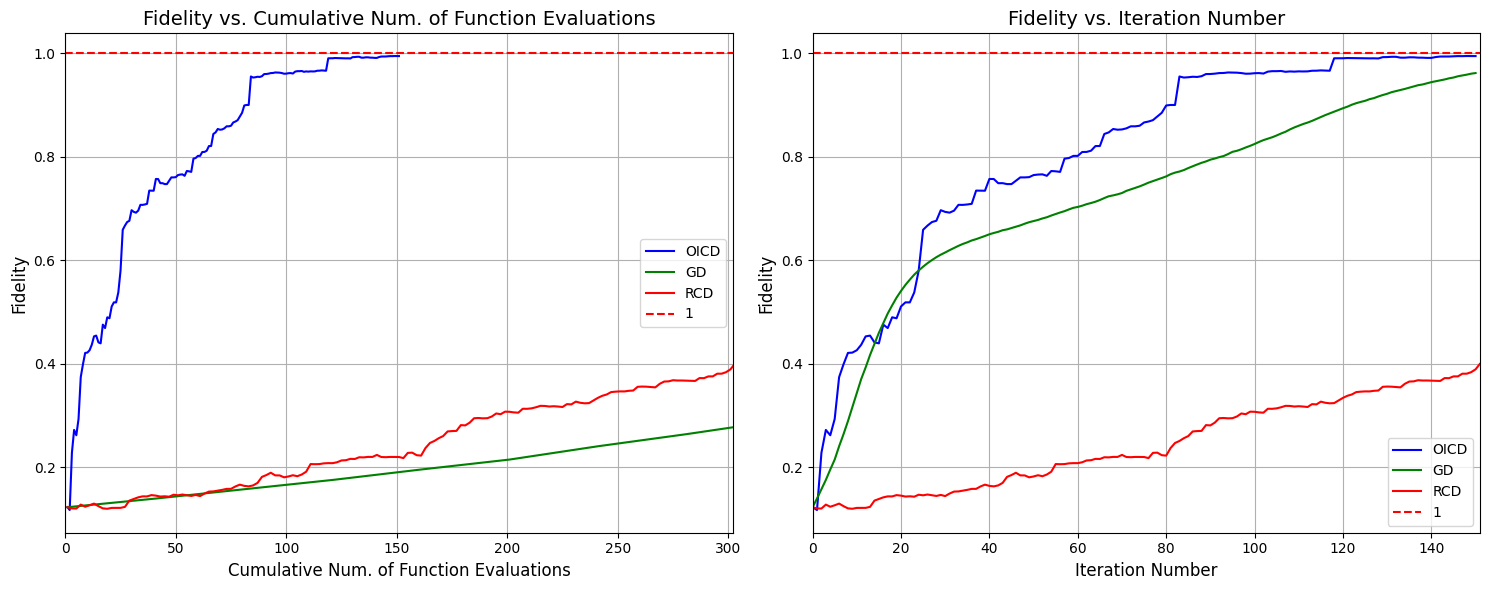

In [12]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# 第一个子图：横坐标是累计函数调用次数，纵坐标是 Fidelity
axs[0].plot(func_oicd, fidelity_record_value_oicd, label='OICD', color='blue')
axs[0].plot(func_gd, fidelity_record_value_gd, label='GD', color='green')
axs[0].plot(func_rcd, fidelity_record_value_rcd, label='RCD', color='red')
axs[0].axhline(y=1, color='r', linestyle='--', label='1')
# 设置第一个子图的标签和标题
axs[0].set_xlabel('Cumulative Num. of Function Evaluations', fontsize=12)
axs[0].set_ylabel('Fidelity', fontsize=12)
axs[0].set_title('Fidelity vs. Cumulative Num. of Function Evaluations', fontsize=14)

# 设置x轴范围
# x_range = np.average([func_oicd[-1], func_gd[-1], func_rcd[-1]])
# x_range = max(func_oicd[-1], func_gd[-1], func_rcd[-1])
# x_range = min(func_oicd[-1], func_gd[-1], func_rcd[-1])
x_range = func_oicd[-1]*2
axs[0].set_xlim(0,x_range)

# 显示第一个子图的图例
axs[0].legend()

# 第二个子图：横坐标是迭代次数，纵坐标是 Fidelity
axs[1].plot(fidelity_record_value_oicd, label='OICD', color='blue')
axs[1].plot(fidelity_record_value_gd, label='GD', color='green')
axs[1].plot(fidelity_record_value_rcd, label='RCD', color='red')
axs[1].axhline(y=1, color='r', linestyle='--', label='1')
# 设置第二个子图的标签和标题
axs[1].set_xlabel('Iteration Number', fontsize=12)
axs[1].set_ylabel('Fidelity', fontsize=12)
axs[1].set_title('Fidelity vs. Iteration Number', fontsize=14)

# 设置x轴范围
axs[1].set_xlim(0, min(len(fidelity_record_value_oicd), len(fidelity_record_value_gd), len(fidelity_record_value_rcd)))

# 显示第二个子图的图例
axs[1].legend()

# 显示网格
for ax in axs:
    ax.grid(True)

# 自动调整布局，避免重叠
plt.tight_layout()

# 显示图形
plt.show()
